# Import Libraries

In [1]:
# Get dataset
!wget https://raw.githubusercontent.com/GoEco-Living/MachineLearning/refs/heads/main/Dataset/meals.csv
!wget https://raw.githubusercontent.com/GoEco-Living/MachineLearning/refs/heads/main/Dataset/transport.csv

--2024-12-02 03:43:47--  https://raw.githubusercontent.com/GoEco-Living/MachineLearning/refs/heads/main/Dataset/meals.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8467 (8.3K) [text/plain]
Saving to: ‘meals.csv’

meals.csv           100%[===================>]   8.27K  --.-KB/s    in 0s      

2024-12-02 03:43:47 (52.0 MB/s) - ‘meals.csv’ saved [8467/8467]

--2024-12-02 03:43:47--  https://raw.githubusercontent.com/GoEco-Living/MachineLearning/refs/heads/main/Dataset/transport.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Lengt

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

# Processing Data

In [2]:
# Load dataset
meals_df = pd.read_csv('meals.csv')
transport_df = pd.read_csv('transport.csv')

In [3]:
meals_df.sample(5)

,Food Item,Carbon kg CO2eq/kg,Category
57,pomegranate,1.17,Vegan
253,porbeagle,11.44,Fish
50,tomato,0.91,Vegan
6,oat,0.67,Vegan
37,watermelon,0.52,Vegan


In [3]:
# Rename category
for index, row in meals_df.iterrows():
    if row['Category'] in ['fish frozen', 'fish processed', 'shellfish', 'shellfish frozen']:
        meals_df.at[index, 'Category'] = 'Fish'
    else:
        meals_df.at[index, 'Category'] = row['Category']

# **Meals Model**

In [5]:
meals_df.sample(5)

,Food Item,Carbon kg CO2eq/kg,Category
305,rabbit meat with bone,4.31,Beef
198,zucchini (f),1.35,Vegan
281,tuna in can,2.10,Fish
68,chestnut,0.44,Vegan
223,cheese semi-hard,8.65,Vegetarian


## Create Model

In [4]:
meals_mapping = {category: idx for idx, category in enumerate(meals_df["Category"].unique())}
meals_df["Category_encoded"] = meals_df["Category"].map(meals_mapping)

# Prepare features and target variable
X = meals_df["Category_encoded"].values.reshape(-1, 1)
y = meals_df["Carbon kg CO2eq/kg"].values.reshape(-1, 1)

# Normalize the target variable (carbon emissions)
scaler = MinMaxScaler()
y_normalized = scaler.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_normalized, test_size=0.2, random_state=42)

def create_meal_model():
    meal_input = tf.keras.layers.Input(shape=(1,), name="meal_input")

    meal_embedding = tf.keras.layers.Embedding(input_dim=len(meals_mapping), output_dim=5)(meal_input)
    meal_flatten = tf.keras.layers.Flatten()(meal_embedding)
    dense_1 = tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(meal_flatten)

    # Menambahkan Dropout untuk mengurangi overfitting
    dropout_1 = tf.keras.layers.Dropout(0.2)(dense_1)

    dense_2 = tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(dropout_1)

    # Output untuk emisi karbon
    carbon_output = tf.keras.layers.Dense(1, activation="linear", name="meal_carbon_output")(dense_2)

    # Create and compile the model
    optimizer = tf.keras.optimizers.Adam()

    model = tf.keras.Model(inputs=[meal_input], outputs=[carbon_output])
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

    return model

In [5]:
meal_model = create_meal_model()
meal_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ meal_input (InputLayer)              │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 1, 5)                │              25 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ meal_carbon_output (Dense)           │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,522 (9.85 KB)

 Trainable params: 2,522 (9.85 KB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [6]:
history = meal_model.fit(X_train, y_train, epochs=100, validation_split=0.6)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.5252 - mae: 0.0346 - val_loss: 0.5106 - val_mae: 0.0357
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5000 - mae: 0.0272 - val_loss: 0.4868 - val_mae: 0.0363
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4770 - mae: 0.0283 - val_loss: 0.4641 - val_mae: 0.0318
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4541 - mae: 0.0213 - val_loss: 0.4425 - val_mae: 0.0294
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4330 - mae: 0.0211 - val_loss: 0.4217 - val_mae: 0.0288
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4120 - mae: 0.0189 - val_loss: 0.4017 - val_mae: 0.0288
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3928 - mae: 0.0214 - val_loss: 0.3826 - val_mae: 0.0291
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3730 - mae: 0.0171 - val_loss: 0.3644 - val_mae: 0.0288
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3559 - mae: 

In [7]:
loss, mae = meal_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}")
print(f"Test MAE: {mae}")

Test Loss: 0.0029712459072470665
Test MAE: 0.024862229824066162


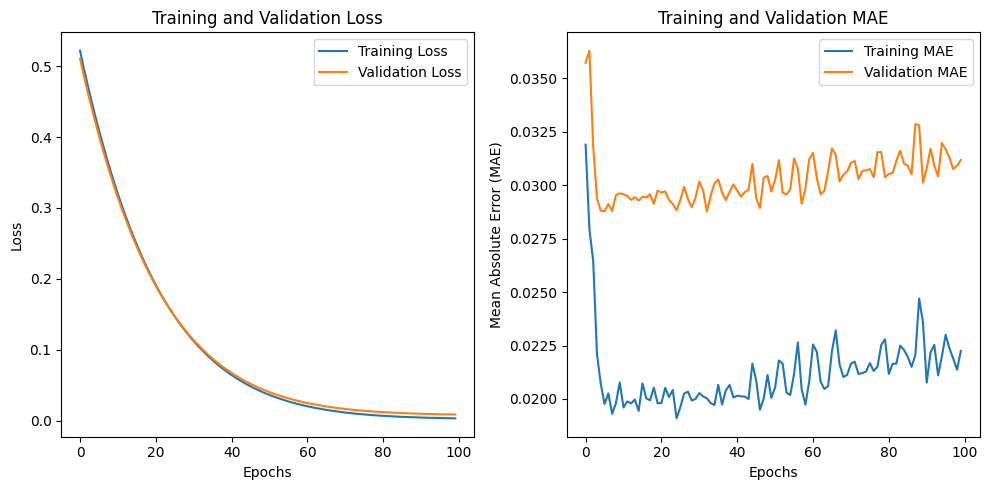

In [8]:
history_data = history.history

# Visualisasi Loss
plt.figure(figsize=(10, 5))

# training loss & validation loss
plt.subplot(1, 2, 1)
plt.plot(history_data['loss'], label='Training Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# MAE
plt.subplot(1, 2, 2)
plt.plot(history_data['mae'], label='Training MAE')
plt.plot(history_data['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
print(meals_mapping)

{'Vegan': 0, 'Vegetarian': 1, 'Fish': 2, 'Beef': 3, 'Chicken': 4}


In [11]:
# Menggunakan indeks yang benar sesuai dengan meals_mapping
sample_category = np.array([meals_mapping['Beef']])
# Prediksi dengan model yang telah dilatih
predicted_carbon = meal_model.predict(sample_category)

# De-normalisasi hasil prediksi karbon untuk mendapatkan nilai asli
predicted_carbon_actual = scaler.inverse_transform(predicted_carbon)

print(f"Predicted carbon emission for the food : {predicted_carbon_actual[0][0]} kg CO2eq")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Predicted carbon emission for the food : 5.930556297302246 kg CO2eq


In [14]:
def recommend_lower_carbon(category_input, model, meals_mapping, scaler):
    # Mengubah kategori input menjadi encoded
    input_index = meals_mapping.get(category_input, None)
    if input_index is None:
        print("Kategori tidak valid.")
        return []

    # Prediksi karbon untuk kategori input
    sample_category = np.array([input_index])
    predicted_carbon = model.predict(sample_category)
    predicted_carbon_actual = scaler.inverse_transform(predicted_carbon)
    user_carbon = predicted_carbon_actual[0][0]

    print(f"Predicted carbon emission for '{category_input}': {user_carbon} kg CO2eq")

    # Menemukan kategori dengan karbon lebih rendah
    lower_carbon_recommendations = []
    for category, index in meals_mapping.items():
        if category != category_input:
            sample_category = np.array([index])
            predicted_carbon = model.predict(sample_category)
            predicted_carbon_actual = scaler.inverse_transform(predicted_carbon)
            carbon_value = predicted_carbon_actual[0][0]

            # Jika karbon lebih rendah, tambahkan ke rekomendasi
            if carbon_value < user_carbon:
                lower_carbon_recommendations.append((category, carbon_value))

    # Sort berdasarkan karbon emisi yang lebih rendah
    lower_carbon_recommendations.sort(key=lambda x: x[1])

    return lower_carbon_recommendations

# Contoh penggunaan
category_input = "Vegetarian"  # Kategori input dari pengguna
lower_carbon_recs = recommend_lower_carbon(category_input, meal_model, meals_mapping, scaler)

# Tampilkan rekomendasi
if lower_carbon_recs:
    print("\nRecommended meals with lower carbon emissions:")
    for rec in lower_carbon_recs:
        print(f"{rec[0]}: {rec[1]:.2f} kg CO2eq")
else:
    print("No meals with lower carbon emissions found.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Predicted carbon emission for 'Vegetarian': 4.853299617767334 kg CO2eq
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step

Recommended meals with lower carbon emissions:
Vegan: 1.93 kg CO2eq
Chicken: 4.62 kg CO2eq


In [9]:
# Save
meal_model.save('meal_model.h5')
print("Model saved")

Model saved
